In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [ ]:
labels_df = pd.read_csv('train_v3.csv')
print(labels_df.head().to_markdown())

|    | id                    |   label |
|---:|:----------------------|--------:|
|  0 | image_rectangular_1   |       0 |
|  1 | image_rectangular_10  |       0 |
|  2 | image_rectangular_100 |       0 |
|  3 | image_rectangular_101 |       0 |
|  4 | image_rectangular_102 |       0 |


In [ ]:
labels_df['label'].value_counts()

0    150
1    150
Name: label, dtype: int64

In [ ]:
imgpath ="/content/train" # training data is stored in this folder
inside = labels_df.loc[labels_df['label']==0]['id'].values
outside = labels_df.loc[labels_df['label']==1]['id'].values

print('inside frames')
print(inside[0:3],'\n')

print('outside frames')
print(outside[0:3])

inside frames
['image_rectangular_1' 'image_rectangular_10' 'image_rectangular_100'] 

outside frames
['outside_geofence_1' 'outside_geofence_10' 'outside_geofence_100']


In [ ]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.png')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

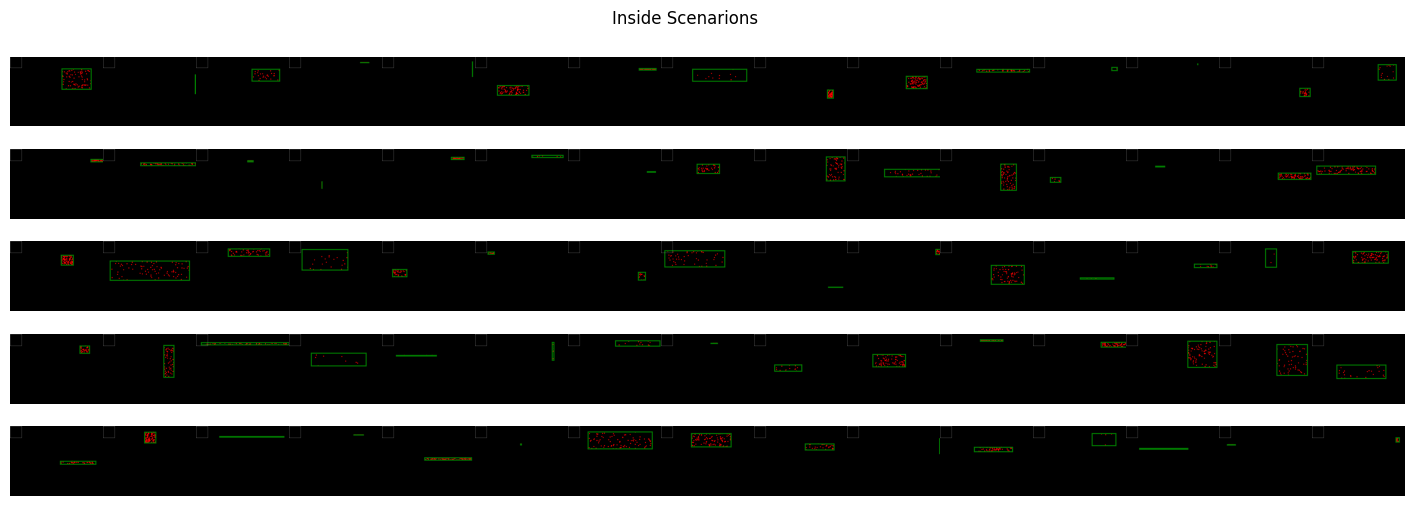

In [ ]:
plot_fig(inside,'Inside Scenarions')

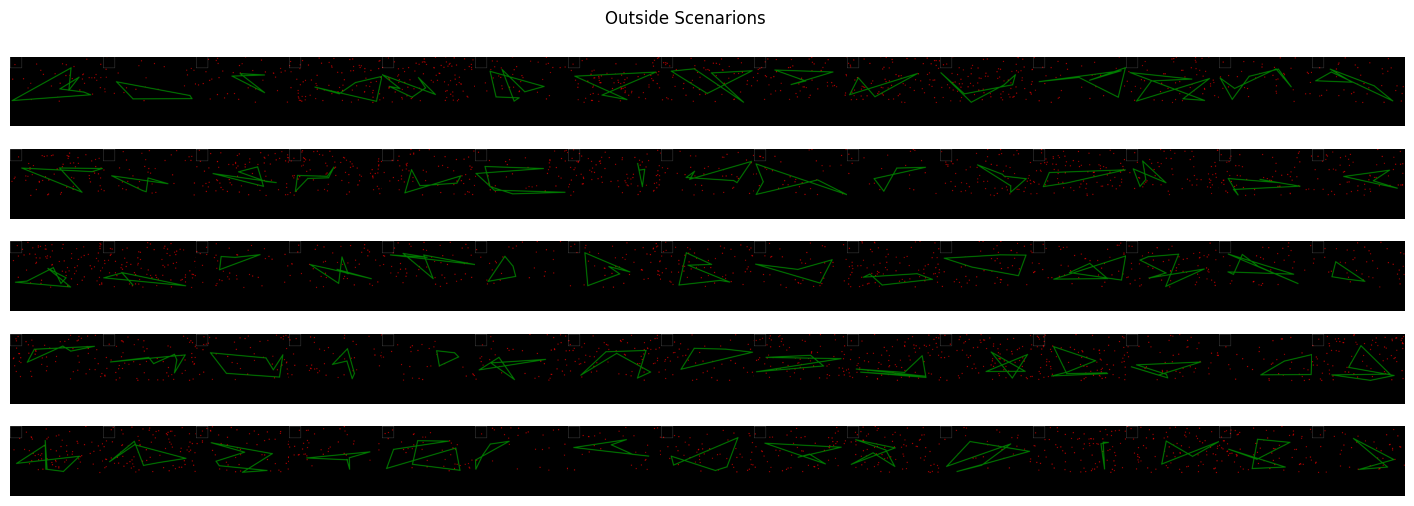

In [ ]:
plot_fig(outside,'Outside Scenarions')

In [ ]:
torch.manual_seed(0)

class pytorch_data(Dataset):

    def __init__(self,data_dir,transform,data_type="train"):


        cdm_data=os.path.join(data_dir,data_type)

        file_names = os.listdir(cdm_data)

        idx_choose = np.random.choice(np.arange(len(file_names)),
                                      280,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]
        # Get Labels
        labels_data=os.path.join('/content/',"train_v3.csv")
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True)
        print(labels_df)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]
        self.transform = transform
        print

    def __len__(self):
        return len(self.full_filenames)
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]


In [ ]:

import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [ ]:
data_dir = '/content/'
img_dataset = pytorch_data(data_dir, data_transformer, "train")

                       label
id                          
image_rectangular_1        0
image_rectangular_10       0
image_rectangular_100      0
image_rectangular_101      0
image_rectangular_102      0
...                      ...
outside_geofence_95        1
outside_geofence_96        1
outside_geofence_97        1
outside_geofence_98        1
outside_geofence_99        1

[300 rows x 1 columns]


In [ ]:

img,label=img_dataset[11]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 46, 46]) tensor(0.) tensor(1.)


In [ ]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train


train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 224
validation dataset size: 56


In [ ]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0


In [ ]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [ ]:
# Create grid of sample images
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)

plot_img(x_grid_train,y_grid_train,'Training Subset Examples')

image indices: [ 85 105  74  16  72 156 171  19  67  65   5  32  87 222 217  61 194 107
 101   9 217 177 157 128 108 114 105  31  10 214]
torch.Size([3, 146, 482])


In [ ]:
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

image indices: [47 54  5  5 32 40 32 29 51 44 30 43  8 29 46 37 42 22 11 43 43 37 45 55
 11  3 17 39 15 12]
torch.Size([3, 146, 482])


In [ ]:

tr_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor()])

In [ ]:

val_transf = transforms.Compose([
    transforms.ToTensor()])

train_ts.transform=tr_transf
val_ts.transform=val_transf

In [ ]:

train_ts.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [ ]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32,
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [ ]:

for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 46, 46]) tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1])


In [ ]:
def findConv2dOutShape(hin,win,conv,pool=2):

    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Custom Neural Network
class Network(nn.Module):

    def __init__(self, params):

        super(Network, self).__init__()

        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"]
        num_fc1=params["num_fc1"]
        num_classes=params["num_classes"]
        self.dropout_rate=params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)


        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [ ]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}


cnn_model = Network(params_model)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [ ]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [ ]:
loss_func = nn.NLLLoss(reduction="sum")

In [ ]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)


    for xb, yb in dataset_dl:

        print(yb)
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False,
}

In [ ]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):


    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value

    ''' Train Model n_epochs '''

    for epoch in tqdm(range(epochs)):

        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        '''

        Train Model Process

        '''

        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        '''

        Evaluate Model Process

        '''

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''


cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 0

Text(0.5, 1.0, 'Convergence History')

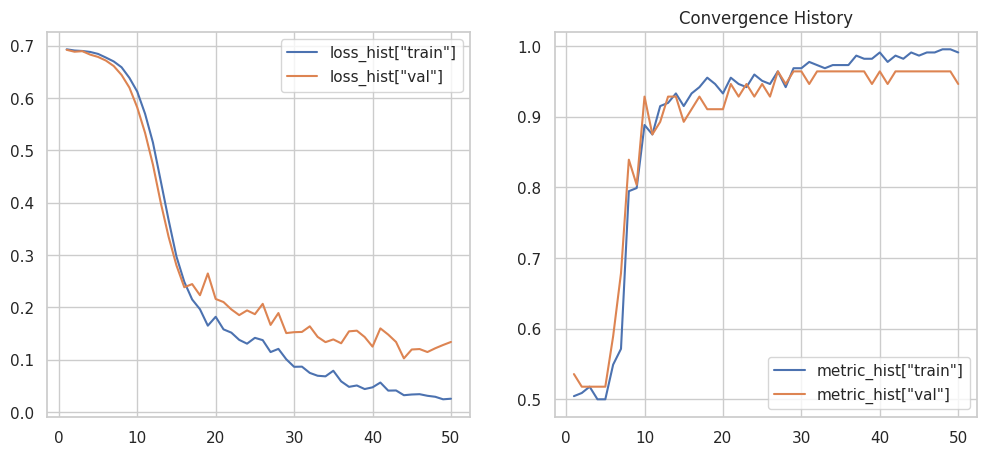

In [ ]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')



In [ ]:
class pytorchdata_test(Dataset):

    def __init__(self, data_dir, transform,data_type="train"):

        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        csv_filename="test_v4.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        labels_df.set_index("id", inplace=True)


        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    def __len__(self):

        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx]) # PIL image
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
!ls

Images	sample_data  test.csv  test_v3.csv  test_v4.csv  train	train.csv  train_v3.csv  weights.pt


In [ ]:
cnn_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

In [ ]:
path_sub = "/content/test_v4.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape

(100, 2)

In [ ]:
data_dir = '/content/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

100 samples found


In [ ]:
def inference(model,dataset,device,num_classes=2):

    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt

In [ ]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



In [ ]:

y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])



(100,)
[1 0 1 0 1]


In [ ]:
# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[1:2])

(100,)
[0.00043809]


In [ ]:
torch.save(cnn_model.state_dict(), 'saved_model.pth')

In [ ]:
cnn_model.eval()

Network(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def loadImage(imageUrl):
    # Image transformations
    data_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((46, 46))
    ])

    image = Image.open(imageUrl)

    # Convert RGBA images to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply transformations
    image = data_transformer(image)

    return image

In [ ]:
with torch.no_grad():
    output = model(loadImage('/content/sample_in.png'))
    predicted_class = torch.argmax(output, dim=1).item()

In [ ]:
class_labels = [0, 1]
predicted_label = class_labels[predicted_class]
print("Predicted label:", predicted_label)

Predicted label: 0


In [ ]:
with torch.no_grad():
    output = model(loadImage('/content/sample_out.png'))
    predicted_class = torch.argmax(output, dim=1).item()

In [ ]:
predicted_label = class_labels[predicted_class]
print("Predicted label:", predicted_label)

Predicted label: 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



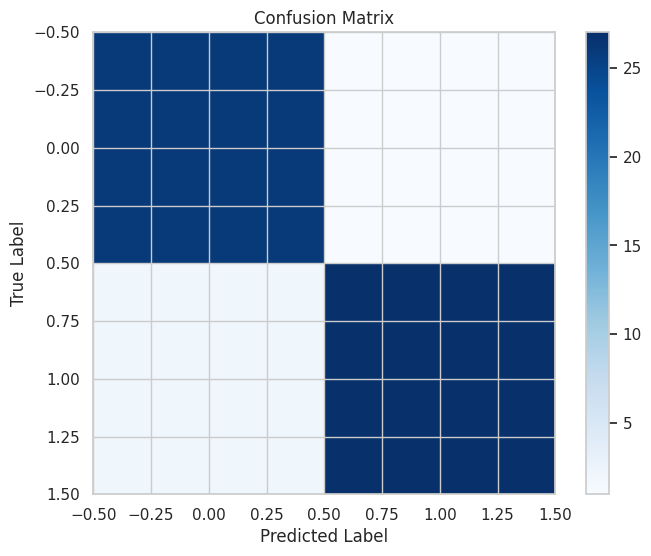

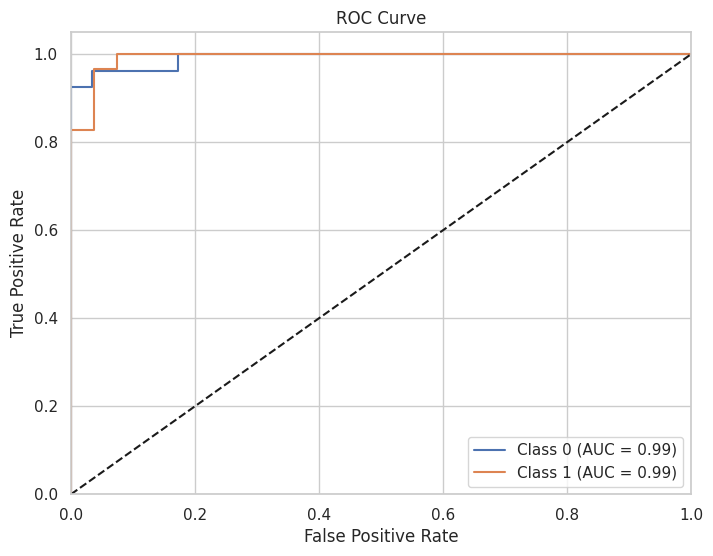

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []


with torch.no_grad():
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())  # Convert labels to numpy array
        predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())  # Convert probabilities to numpy array

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predicted_probs, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
